In [6]:
#importing libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt
import math
import pickle
from Utils.data_generator import LiteDataGenerator as DataGenerator
from Utils.validation_callback import AdditionalValidationSets, create_validation_sets

In [7]:
BF = pd.read_csv("Data/Batting_First.csv")
BS = pd.read_csv("Data/Chasing.csv")
set_players = set()
for df in [BS, BF]:
    for col in ["Striker", "Non_Striker", "Bowler"]:
        set_players = set_players.union(set(df[col]))
list(set_players)

['MK Tiwary',
 'Yashpal Singh',
 'Harbhajan Singh',
 'D Short',
 'SM Katich',
 'A Uniyal',
 'A Singh',
 'C de Grandhomme',
 'V Kohli',
 'P Parameswaran',
 'T Henderson',
 'Y Nagar',
 'S Rana',
 'LMP Simmons',
 'S Curran',
 'CR Woakes',
 'P Negi',
 'H Viljoen',
 'Shahid Afridi',
 'H Das',
 'M Kartik',
 'N Rana',
 'PM Sarvesh Kumar',
 'MJ Clarke',
 'Sunny Gupta',
 'JA Morkel',
 'M Wood',
 'C Ganapathy',
 'DM Bravo',
 'V Pratap Singh',
 'Mohammad Nabi',
 'AP Tare',
 'Anand Rajan',
 'S Singh',
 'MM Patel',
 'AR Patel',
 'Shakib Al Hasan',
 'MG Johnson',
 'AB Agarkar',
 'S Rutherford',
 'MR Marsh',
 'M Vijay',
 'I Udana',
 'JE Taylor',
 'TA Boult',
 'Z Khan',
 'Ankit Soni',
 'Pankaj Singh',
 'DJ Muthuswami',
 'TM Head',
 'SD Lad',
 'RR Powar',
 'RE Levi',
 'DR Smith',
 'JL Pattinson',
 'KK Cooper',
 'Jaskaran Singh',
 'D Willey',
 'P Sahu',
 'GJ Bailey',
 'G Gambhir',
 'R Sathish',
 'Harmeet Singh (2)',
 'T Shamsi',
 'V Sehwag',
 'BB Sran',
 'S Hetmyer',
 'SS Agarwal',
 'SL Malinga',
 'FH E

## Batting First

In [2]:
BF = pd.read_csv("Data/Batting_First.csv")
BF_clean = BF.drop(columns=["Toss", "Striker_Runs", "Striker_Balls", "Non_Striker_Runs", "Non_Striker_Balls",
                            "Bowler_Runs", "Bowler_Runs", "Bowler_Overs", "Bowler_Balls", "Bowler_Wickets"])
print(BF_clean.columns)


Index(['Venue', 'Batting_Team', 'Bowling_Team', 'Current_Score', 'Wickets',
       'Overs', 'Balls', 'Striker', 'Non_Striker', 'Bowler', 'Free_Hit',
       'Result'],
      dtype='object')


In [3]:
# BF = pd.read_csv("Data/Batting_First.csv")
window_size = 12
batch_size = 16
bf_train_gen = DataGenerator(BF_clean, window_size, batch_size)
bf_test_gen = DataGenerator(BF_clean, window_size, batch_size, validate=True)
validation_sets = create_validation_sets(BF_clean, ((1, 5), (6, 10), (11, 15), (16, 20)),
                                         window_size=window_size,
                                         batch_size=batch_size)

In [4]:
# with open('Data\BF_Cols.pkl', 'wb') as f:
#     pickle.dump(bf_train_gen.inp_cols, f)

In [5]:
# model_inn_1 = tf.keras.Sequential([
#   tf.keras.layers.Dense(512, input_shape=(None, bf_test_gen[0][0].shape[-1])),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.SimpleRNN(256, return_sequences=True),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.SimpleRNN(128, return_sequences=True),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.SimpleRNN(64, return_sequences=True),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(57, activation='softmax')
# ])
# model_inn_1.summary()

In [6]:
model_inn_1 = tf.keras.models.load_model('Models\\Inn1-NewSimpleRNN-ep20to50\\cp-0030.h5')
model_inn_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, None, 512)         794624    
                                                                 
 dropout_27 (Dropout)        (None, None, 512)         0         
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, None, 256)         196864    
                                                                 
 dropout_28 (Dropout)        (None, None, 256)         0         
                                                                 
 simple_rnn_22 (SimpleRNN)   (None, None, 128)         49280     
                                                                 
 dropout_29 (Dropout)        (None, None, 128)         0         
                                                                 
 simple_rnn_23 (SimpleRNN)   (None, 64)               

In [7]:
start = 50
epochs = 50
validation_callback = AdditionalValidationSets(validation_sets)
checkpoint_path_1 = (f"Models/Inn1-NewSimpleRNN-ep{start}to{start+epochs}/"
                     "cp-{epoch:04d}.h5")
model_checkpoint_callback_1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_1)
model_inn_1.compile(
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam())
history = model_inn_1.fit(bf_train_gen,
                validation_data=bf_test_gen,
                epochs=epochs,
                callbacks=[model_checkpoint_callback_1, AdditionalValidationSets(validation_sets)] # , PlotLossesKeras()]
                )

Epoch 1/50
3819/3819 [==============================] - 1042s 272ms/step - loss: 1.7438 - accuracy: 0.4252 - val_loss: 1.7406 - val_accuracy: 0.4156
Epoch 2/50
3819/3819 [==============================] - 1079s 283ms/step - loss: 1.7406 - accuracy: 0.4239 - val_loss: 1.7452 - val_accuracy: 0.4144
Epoch 3/50
3819/3819 [==============================] - 1278s 335ms/step - loss: 1.7406 - accuracy: 0.4241 - val_loss: 1.7398 - val_accuracy: 0.4169
Epoch 4/50
3819/3819 [==============================] - 1190s 311ms/step - loss: 1.7403 - accuracy: 0.4236 - val_loss: 1.7400 - val_accuracy: 0.4076
Epoch 5/50
3819/3819 [==============================] - 1038s 272ms/step - loss: 1.7399 - accuracy: 0.4238 - val_loss: 1.7375 - val_accuracy: 0.4158
Epoch 6/50
3819/3819 [==============================] - 1072s 281ms/step - loss: 1.7404 - accuracy: 0.4231 - val_loss: 1.7503 - val_accuracy: 0.4161
Epoch 7/50
3819/3819 [==============================] - 1094s 287ms/step - loss: 1.7394 - accuracy: 0.4210

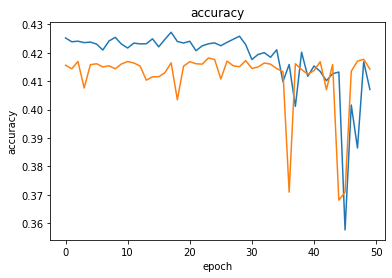

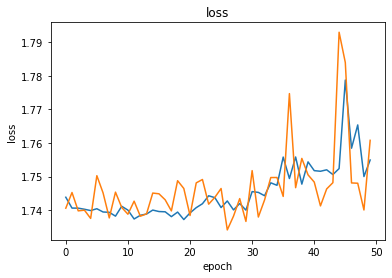

In [8]:
history_val_callback = history.history
for key in sorted([i for i in history_val_callback if i.split("_")[0]!="val"]):
    plt.plot(history_val_callback[key])
    plt.plot(history_val_callback["val_"+key])
    plt.xlabel('epoch')
    plt.ylabel(key)
    plt.title(key)
    plt.show()

## Chasing

In [9]:
# del bf_train_gen, bf_test_gen
BS = pd.read_csv("Data/Chasing.csv")
BS_clean = BS.drop(columns=["Toss", "Striker_Runs", "Striker_Balls", "Non_Striker_Runs", "Non_Striker_Balls",
                            "Bowler_Runs", "Bowler_Runs", "Bowler_Overs", "Bowler_Balls", "Bowler_Wickets"])
print(BS_clean.columns)

Index(['Venue', 'Batting_Team', 'Bowling_Team', 'Current_Score', 'Wickets',
       'Overs', 'Balls', 'Striker', 'Non_Striker', 'Bowler', 'Free_Hit',
       'Target', 'Result'],
      dtype='object')


In [10]:
# numerical_cols = ['Current_Score', 'Wickets', 'Overs', 'Balls', 'Target']
# norm_dic = {}
# BS_Norm = BS_clean.copy()
# for numerical_col in numerical_cols:
#     col_min = np.min(BS_Norm[numerical_col])
#     col_max = np.max(BS_Norm[numerical_col])

#     norm_dic[numerical_col] = (col_min, col_max)
#     BS_Norm[numerical_col] = (BS_Norm[numerical_col] - col_min) / (col_max - col_min)
# print(norm_dic)
# BS_Norm.describe()

In [11]:
window_size = 12
batch_size = 64
val_overs = ((1, 5), (6, 10), (11, 15), (16, 20))
# print(val_overs_norm)
bs_train_gen = DataGenerator(BS_clean, window_size, batch_size)
bs_test_gen = DataGenerator(BS_clean, window_size, batch_size, validate=True)
validation_sets = create_validation_sets(BS_clean, val_overs,
                                         window_size=window_size,
                                         batch_size=batch_size)

In [12]:
# with open('Data\BS_Cols.pkl', 'wb') as f:
#     pickle.dump(bs_test_gen.inp_cols, f)

In [5]:
model_inn_2= tf.keras.Sequential([
  tf.keras.layers.Dense(512, input_shape=(None, bs_test_gen[0][0].shape[-1])),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.SimpleRNN(256, return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.SimpleRNN(128, return_sequences=True),s
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.SimpleRNN(64, return_sequences=False),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(57, activation='softmax')
])
model_inn_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 512)         795136    
                                                                 
 dropout (Dropout)           (None, None, 512)         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 256)         196864    
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 128)         49280     
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                1

In [13]:
model_inn_2 = tf.keras.models.load_model('Models\\Inn2-NewSimpleRNN-ep20to40\\cp-0020.h5')

In [14]:
start = 40
epochs = 60
validation_callback = AdditionalValidationSets(validation_sets)
checkpoint_path_2 = (f"Models/Inn2-NewSimpleRNN-ep{start}to{start+epochs}/"
                     "cp-{epoch:04d}.h5")
model_checkpoint_callback_2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2,
    save_freq=len(bs_train_gen))
model_inn_2.compile(
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam())
history = model_inn_2.fit(bs_train_gen,
                validation_data=bs_test_gen,
                epochs=epochs,
                callbacks=[model_checkpoint_callback_2, AdditionalValidationSets(validation_sets)] # , PlotLossesKeras()]
                )

Epoch 1/60
897/897 [==============================] - 855s 952ms/step - loss: 1.7277 - accuracy: 0.4172 - val_loss: 1.7456 - val_accuracy: 0.4119
Epoch 2/60
897/897 [==============================] - 854s 953ms/step - loss: 1.7254 - accuracy: 0.4174 - val_loss: 1.7469 - val_accuracy: 0.4118
Epoch 3/60
897/897 [==============================] - 851s 950ms/step - loss: 1.7248 - accuracy: 0.4173 - val_loss: 1.7453 - val_accuracy: 0.4097
Epoch 4/60
897/897 [==============================] - 848s 945ms/step - loss: 1.7255 - accuracy: 0.4192 - val_loss: 1.7440 - val_accuracy: 0.4007
Epoch 5/60
253/897 [=======>......................] - ETA: 6:57 - loss: 1.7281 - accuracy: 0.4183

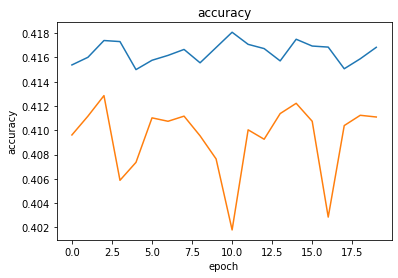

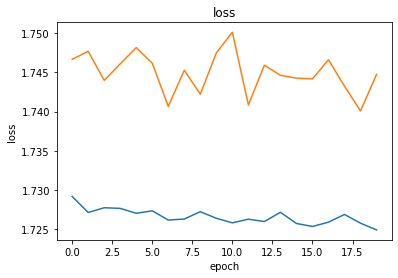

In [ ]:
history_val_callback = history.history
for key in sorted([i for i in history_val_callback if i.split("_")[0]!="val"]):
    plt.plot(history_val_callback[key])
    plt.plot(history_val_callback["val_"+key])
    plt.xlabel('epoch')
    plt.ylabel(key)
    plt.title(key)
    plt.show()

## Visualization

In [10]:
import re
cont = 0
with open("Models\\Inn2-NewSimpleRNN-ep0to20\\progress.txt") as fp:
    txt_file = fp.read()
pat = re.compile(r"Epoch \d+/\d+\n"
                 r".*?loss: (\d+\.?\d*) - accuracy: (\d+\.?\d*)\n"
                 r".*?loss: (\d+\.?\d*) - accuracy: (\d+\.?\d*)\n"
                 r".*?loss: (\d+\.?\d*) - accuracy: (\d+\.?\d*)\n"
                 r".*?loss: (\d+\.?\d*) - accuracy: (\d+\.?\d*)\n"
                 r".*?loss: (\d+\.?\d*) - accuracy: (\d+\.?\d*) - val_loss: (\d+\.?\d*) - val_accuracy: (\d+\.?\d*)"
                 )
matches = re.findall(pat, txt_file)
if not cont:
    history = {"val_loss_1to5": [],
            "val_accuracy_1to5": [],
            "val_loss_6to10": [],
            "val_accuracy_6to10": [],
            "val_loss_11to15": [],
            "val_accuracy_11to15": [],
            "val_loss_16to20": [],
            "val_accuracy_16to20": [],
            "train_loss": [],
            "train_accuracy": [],
            "val_loss": [],
            "val_accuracy": [],
            }
val_overs = ((1, 5), (6, 10), (11, 15), (16, 20))
for ep in matches:
    for ind, (start, end) in enumerate(val_overs):
        history[f"val_loss_{start}to{end}"].append(float(ep[ind*2]))
        history[f"val_accuracy_{start}to{end}"].append(float(ep[ind*2 + 1]))
    history[f"train_loss"].append(float(ep[8]))
    history[f"train_accuracy"].append(float(ep[9]))
    history[f"val_loss"].append(float(ep[10]))
    history[f"val_accuracy"].append(float(ep[11]))

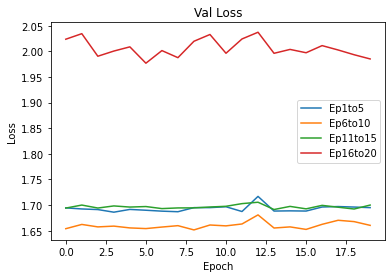

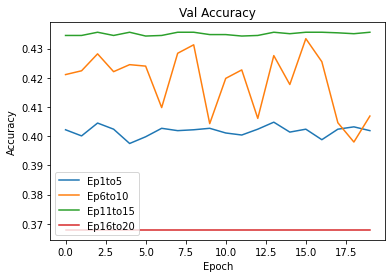

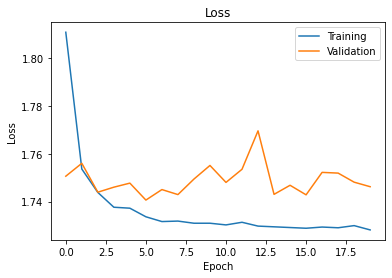

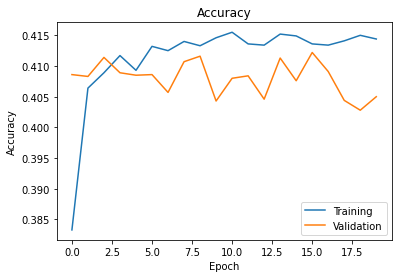

In [11]:
for (start, end) in val_overs:
    plt.plot(history[f"val_loss_{start}to{end}"], label=f"Ep{start}to{end}")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Val Loss")
plt.show()

for (start, end) in val_overs:
    plt.plot(history[f"val_accuracy_{start}to{end}"], label=f"Ep{start}to{end}")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.title("Val Accuracy")
plt.show()

plt.plot(history["train_loss"], label="Training")
plt.plot(history["val_loss"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

plt.plot(history["train_accuracy"], label="Training")
plt.plot(history["val_accuracy"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.show()